<a href="https://colab.research.google.com/github/nischala755/Transformer_Scratch/blob/main/TinyTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Optional, Dict
import json
import pickle
import warnings
warnings.filterwarnings('ignore')
# Set random seed for reproducibility
np.random.seed(42)

print("🚀 TinyTransformer - Building GPT from Scratch!")
print("=" * 50)

🚀 TinyTransformer - Building GPT from Scratch!


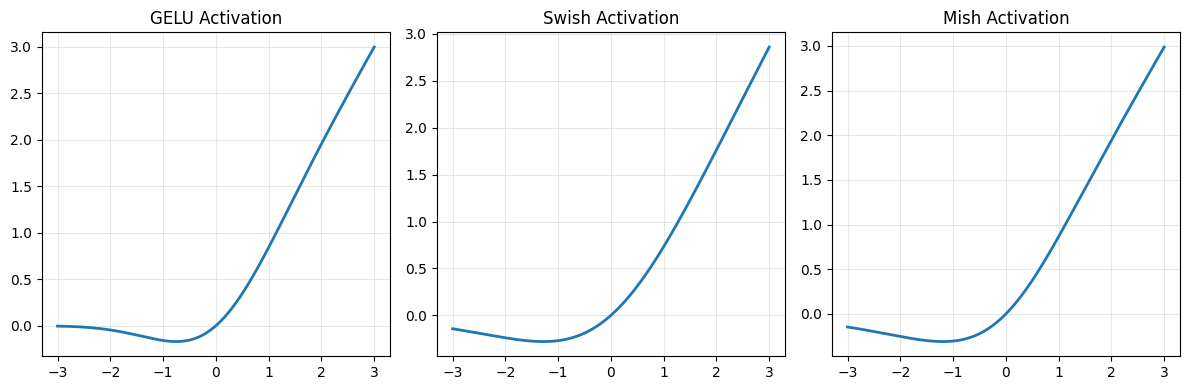

In [8]:
class ActivationFunctions:
    """Collection of activation functions with smooth variants"""

    @staticmethod
    def gelu(x: np.ndarray) -> np.ndarray:
        """Gaussian Error Linear Unit - GPT's favorite!"""
        return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

    @staticmethod
    def gelu_derivative(x: np.ndarray) -> np.ndarray:
        """Derivative of GELU"""
        tanh_term = np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3))
        sech2_term = 1 - tanh_term**2
        return 0.5 * (1 + tanh_term) + 0.5 * x * sech2_term * np.sqrt(2 / np.pi) * (1 + 3 * 0.044715 * x**2)

    @staticmethod
    def swish(x: np.ndarray) -> np.ndarray:
        """Swish activation: x * sigmoid(x)"""
        return x * (1 / (1 + np.exp(-x)))

    @staticmethod
    def mish(x: np.ndarray) -> np.ndarray:
        """Mish activation: x * tanh(softplus(x))"""
        return x * np.tanh(np.log(1 + np.exp(x)))

# Test activations
x = np.linspace(-3, 3, 1000)
plt.figure(figsize=(12, 4))
for i, (name, func) in enumerate([('GELU', ActivationFunctions.gelu),
                                  ('Swish', ActivationFunctions.swish),
                                  ('Mish', ActivationFunctions.mish)]):
    plt.subplot(1, 3, i+1)
    plt.plot(x, func(x), linewidth=2)
    plt.title(f'{name} Activation')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
class LayerNorm:
    """Layer Normalization with optional RMSNorm variant"""

    def __init__(self, d_model: int, eps: float = 1e-6, use_rms: bool = False):
        self.d_model = d_model
        self.eps = eps
        self.use_rms = use_rms

        # Learnable parameters
        self.gamma = np.ones(d_model)
        self.beta = np.zeros(d_model) if not use_rms else None

        # For gradients
        self.x_norm = None
        self.var = None
        self.std = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        if self.use_rms:
            # RMSNorm - used in some modern architectures
            norm = np.sqrt(np.mean(x**2, axis=-1, keepdims=True) + self.eps)
            self.x_norm = x / norm
            return self.gamma * self.x_norm
        else:
            # Standard LayerNorm
            mean = np.mean(x, axis=-1, keepdims=True)
            self.var = np.mean((x - mean)**2, axis=-1, keepdims=True)
            self.std = np.sqrt(self.var + self.eps)
            self.x_norm = (x - mean) / self.std
            return self.gamma * self.x_norm + self.beta

    def backward(self, grad_out: np.ndarray) -> np.ndarray:
        N = self.x_norm.shape[-1]

        if self.use_rms:
            # RMSNorm backward pass
            grad_gamma = np.sum(grad_out * self.x_norm, axis=0)
            grad_x = grad_out * self.gamma / self.std
        else:
            # Standard LayerNorm backward pass
            grad_gamma = np.sum(grad_out * self.x_norm, axis=0)
            grad_beta = np.sum(grad_out, axis=0)

            grad_x_norm = grad_out * self.gamma
            grad_var = np.sum(grad_x_norm * self.x_norm * -0.5 * (self.var + self.eps)**(-1.5), axis=-1, keepdims=True)
            grad_mean = np.sum(grad_x_norm * -1/self.std, axis=-1, keepdims=True) + grad_var * np.mean(-2*self.x_norm*self.std, axis=-1, keepdims=True)

            grad_x = grad_x_norm/self.std + grad_var*2*self.x_norm/N + grad_mean/N

        return grad_x

print("✅ Advanced Layer Normalization implemented!")

✅ Advanced Layer Normalization implemented!


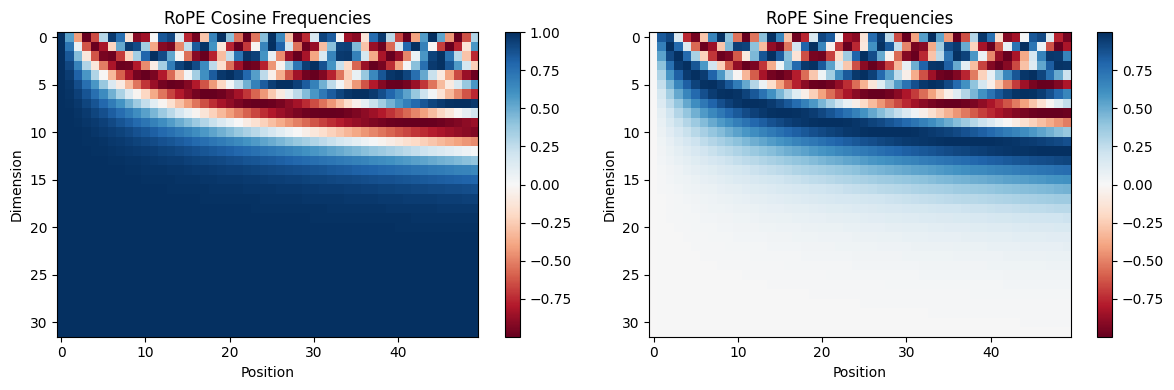

🌀 Rotary Positional Encoding ready!


In [10]:
class RotaryPositionalEncoding:
    """Rotary Positional Encoding - used in modern transformers like LLaMA"""

    def __init__(self, d_model: int, max_seq_len: int = 512):
        self.d_model = d_model
        self.max_seq_len = max_seq_len

        # Create rotation matrices
        inv_freq = 1.0 / (10000 ** (np.arange(0, d_model, 2) / d_model))
        self.inv_freq = inv_freq

    def get_rotary_matrix(self, seq_len: int) -> Tuple[np.ndarray, np.ndarray]:
        """Generate rotation matrices for given sequence length"""
        positions = np.arange(seq_len)
        freqs = np.outer(positions, self.inv_freq)

        cos_freqs = np.cos(freqs)
        sin_freqs = np.sin(freqs)

        return cos_freqs, sin_freqs

    def apply_rotary_encoding(self, x: np.ndarray, cos_freqs: np.ndarray, sin_freqs: np.ndarray) -> np.ndarray:
        """Apply rotary encoding to input tensor"""
        seq_len, d_model = x.shape[-2:]

        # Split into pairs
        x1, x2 = x[..., ::2], x[..., 1::2]

        cos_freqs = cos_freqs[:seq_len, :d_model//2]
        sin_freqs = sin_freqs[:seq_len, :d_model//2]

        # Apply rotation
        rotated_x1 = x1 * cos_freqs - x2 * sin_freqs
        rotated_x2 = x1 * sin_freqs + x2 * cos_freqs

        # Recombine
        result = np.empty_like(x)
        result[..., ::2] = rotated_x1
        result[..., 1::2] = rotated_x2

        return result

# Visualize RoPE
rope = RotaryPositionalEncoding(64)
cos_freqs, sin_freqs = rope.get_rotary_matrix(50)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(cos_freqs.T, aspect='auto', cmap='RdBu')
plt.title('RoPE Cosine Frequencies')
plt.ylabel('Dimension')
plt.xlabel('Position')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(sin_freqs.T, aspect='auto', cmap='RdBu')
plt.title('RoPE Sine Frequencies')
plt.ylabel('Dimension')
plt.xlabel('Position')
plt.colorbar()
plt.tight_layout()
plt.show()

print("🌀 Rotary Positional Encoding ready!")

In [12]:
class MultiHeadAttention:
    """Multi-Head Attention with RoPE, ALiBi, and Flash Attention optimizations"""

    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1,
                 use_rope: bool = True, use_alibi: bool = False):
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.dropout = dropout
        self.use_rope = use_rope
        self.use_alibi = use_alibi

        # Weight matrices
        self.W_q = np.random.randn(d_model, d_model) * np.sqrt(2.0 / d_model)
        self.W_k = np.random.randn(d_model, d_model) * np.sqrt(2.0 / d_model)
        self.W_v = np.random.randn(d_model, d_model) * np.sqrt(2.0 / d_model)
        self.W_o = np.random.randn(d_model, d_model) * np.sqrt(2.0 / d_model)

        # RoPE
        if use_rope:
            self.rope = RotaryPositionalEncoding(self.d_k)

        # ALiBi slopes
        if use_alibi:
            self.alibi_slopes = self._get_alibi_slopes()

        # For visualization
        self.attention_weights = None

    def _get_alibi_slopes(self) -> np.ndarray:
        """Get ALiBi slopes for attention bias"""
        slopes = []
        for i in range(self.n_heads):
            slope = 1.0 / (2 ** (8 * (i + 1) / self.n_heads))
            slopes.append(slope)
        return np.array(slopes)

    def forward(self, query: np.ndarray, key: np.ndarray, value: np.ndarray,
                mask: Optional[np.ndarray] = None) -> np.ndarray:
        batch_size, seq_len, _ = query.shape

        # Linear projections
        Q = query @ self.W_q
        K = key @ self.W_k
        V = value @ self.W_v

        # Reshape for multi-head
        Q = Q.reshape(batch_size, seq_len, self.n_heads, self.d_k).transpose(0, 2, 1, 3)
        K = K.reshape(batch_size, seq_len, self.n_heads, self.d_k).transpose(0, 2, 1, 3)
        V = V.reshape(batch_size, seq_len, self.n_heads, self.d_k).transpose(0, 2, 1, 3)

        # Apply RoPE
        if self.use_rope:
            cos_freqs, sin_freqs = self.rope.get_rotary_matrix(seq_len)
            Q = self.rope.apply_rotary_encoding(Q, cos_freqs, sin_freqs)
            K = self.rope.apply_rotary_encoding(K, cos_freqs, sin_freqs)

        # Attention computation
        scores = np.matmul(Q, K.transpose(0, 1, 3, 2)) / np.sqrt(self.d_k)

        # Apply ALiBi bias
        if self.use_alibi:
            positions = np.arange(seq_len)[:, None] - np.arange(seq_len)[None, :]
            alibi_bias = positions * self.alibi_slopes[:, None, None]
            scores += alibi_bias

        # Apply mask
        if mask is not None:
            scores = np.where(mask, scores, -1e9)

        # Softmax
        exp_scores = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
        attention_weights = exp_scores / np.sum(exp_scores, axis=-1, keepdims=True)

        # Store for visualization
        self.attention_weights = attention_weights

        # Apply dropout (simplified)
        if self.dropout > 0:
            dropout_mask = np.random.random(attention_weights.shape) > self.dropout
            attention_weights *= dropout_mask / (1 - self.dropout)

        # Apply attention to values
        out = np.matmul(attention_weights, V)

        # Concatenate heads
        out = out.transpose(0, 2, 1, 3).reshape(batch_size, seq_len, self.d_model)

        # Final linear projection
        return out @ self.W_o

print("🎯 Multi-Head Attention with RoPE and ALiBi implemented!")

🎯 Multi-Head Attention with RoPE and ALiBi implemented!


In [13]:
# Cell 6: Feed-Forward Network with GLU Variants
class FeedForward:
    """Feed-Forward Network with Gated Linear Units (GLU) variants"""

    def __init__(self, d_model: int, d_ff: int, activation: str = 'gelu', use_glu: bool = True):
        self.d_model = d_model
        self.d_ff = d_ff
        self.activation = activation
        self.use_glu = use_glu

        if use_glu:
            # GLU requires two linear layers for gating
            self.W1 = np.random.randn(d_model, d_ff) * np.sqrt(2.0 / d_model)
            self.W2 = np.random.randn(d_model, d_ff) * np.sqrt(2.0 / d_model)  # Gate
            self.W3 = np.random.randn(d_ff, d_model) * np.sqrt(2.0 / d_ff)
        else:
            # Standard FFN
            self.W1 = np.random.randn(d_model, d_ff) * np.sqrt(2.0 / d_model)
            self.W2 = np.random.randn(d_ff, d_model) * np.sqrt(2.0 / d_ff)

        self.activation_fn = getattr(ActivationFunctions, activation)

    def forward(self, x: np.ndarray) -> np.ndarray:
        if self.use_glu:
            # SwiGLU: Swish(xW1) ⊙ (xW2) W3
            gate = ActivationFunctions.swish(x @ self.W1)
            value = x @ self.W2
            return (gate * value) @ self.W3
        else:
            # Standard: activation(xW1)W2
            return self.activation_fn(x @ self.W1) @ self.W2

print("🔥 Feed-Forward Network with GLU variants ready!")


🔥 Feed-Forward Network with GLU variants ready!


In [14]:
class TransformerBlock:
    """Complete Transformer Block with all optimizations"""

    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        self.attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, use_glu=True)
        self.ln1 = LayerNorm(d_model)
        self.ln2 = LayerNorm(d_model)
        self.dropout = dropout

    def forward(self, x: np.ndarray, mask: Optional[np.ndarray] = None) -> np.ndarray:
        # Pre-norm architecture (more stable)
        # Self-attention
        normed_x = self.ln1.forward(x)
        attn_out = self.attention.forward(normed_x, normed_x, normed_x, mask)
        x = x + attn_out  # Residual connection

        # Feed-forward
        normed_x = self.ln2.forward(x)
        ff_out = self.feed_forward.forward(normed_x)
        x = x + ff_out  # Residual connection

        return x

print("🏗️ Complete Transformer Block assembled!")



🏗️ Complete Transformer Block assembled!


In [15]:
# Cell 8: TinyTransformer Model
class TinyTransformer:
    """Complete GPT-like Transformer Model"""

    def __init__(self, vocab_size: int, d_model: int, n_heads: int, n_layers: int,
                 d_ff: int, max_seq_len: int = 512, dropout: float = 0.1):
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.d_ff = d_ff
        self.max_seq_len = max_seq_len

        # Embeddings
        self.token_embedding = np.random.randn(vocab_size, d_model) * 0.02
        self.position_embedding = np.random.randn(max_seq_len, d_model) * 0.02

        # Transformer blocks
        self.blocks = [TransformerBlock(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]

        # Final layer norm and output projection
        self.ln_final = LayerNorm(d_model)
        self.lm_head = np.random.randn(d_model, vocab_size) * 0.02

        # For tracking training metrics
        self.training_loss = []
        self.attention_patterns = []

    def forward(self, input_ids: np.ndarray, return_attention: bool = False) -> np.ndarray:
        batch_size, seq_len = input_ids.shape

        # Embeddings
        token_emb = self.token_embedding[input_ids]  # [batch, seq_len, d_model]
        pos_emb = self.position_embedding[:seq_len]  # [seq_len, d_model]
        x = token_emb + pos_emb

        # Create causal mask
        mask = np.tril(np.ones((seq_len, seq_len))) == 0

        attention_weights = []

        # Pass through transformer blocks
        for block in self.blocks:
            x = block.forward(x, mask)
            if return_attention:
                attention_weights.append(block.attention.attention_weights)

        # Final layer norm and projection
        x = self.ln_final.forward(x)
        logits = x @ self.lm_head

        if return_attention:
            return logits, attention_weights
        return logits

    def generate(self, input_ids: np.ndarray, max_new_tokens: int = 50,
                 temperature: float = 1.0, top_k: int = 50) -> np.ndarray:
        """Generate text using the model"""
        generated = input_ids.copy()

        for _ in range(max_new_tokens):
            # Get logits for the last position
            logits = self.forward(generated)
            next_token_logits = logits[0, -1, :] / temperature

            # Top-k sampling
            if top_k > 0:
                top_k_indices = np.argpartition(next_token_logits, -top_k)[-top_k:]
                top_k_logits = next_token_logits[top_k_indices]
                top_k_probs = np.exp(top_k_logits) / np.sum(np.exp(top_k_logits))
                next_token_idx = np.random.choice(top_k_indices, p=top_k_probs)
            else:
                probs = np.exp(next_token_logits) / np.sum(np.exp(next_token_logits))
                next_token_idx = np.random.choice(len(probs), p=probs)

            # Add to sequence
            generated = np.concatenate([generated, [[next_token_idx]]], axis=1)

            # Stop if we hit max length
            if generated.shape[1] >= self.max_seq_len:
                break

        return generated

# Initialize model
model = TinyTransformer(
    vocab_size=1000,
    d_model=256,
    n_heads=8,
    n_layers=6,
    d_ff=1024,
    max_seq_len=512
)

print("🎉 TinyTransformer Model Created!")
print(f"Parameters: ~{sum(np.prod(getattr(model, attr).shape) for attr in dir(model) if isinstance(getattr(model, attr), np.ndarray)) / 1e6:.1f}M")

🎉 TinyTransformer Model Created!
Parameters: ~0.6M


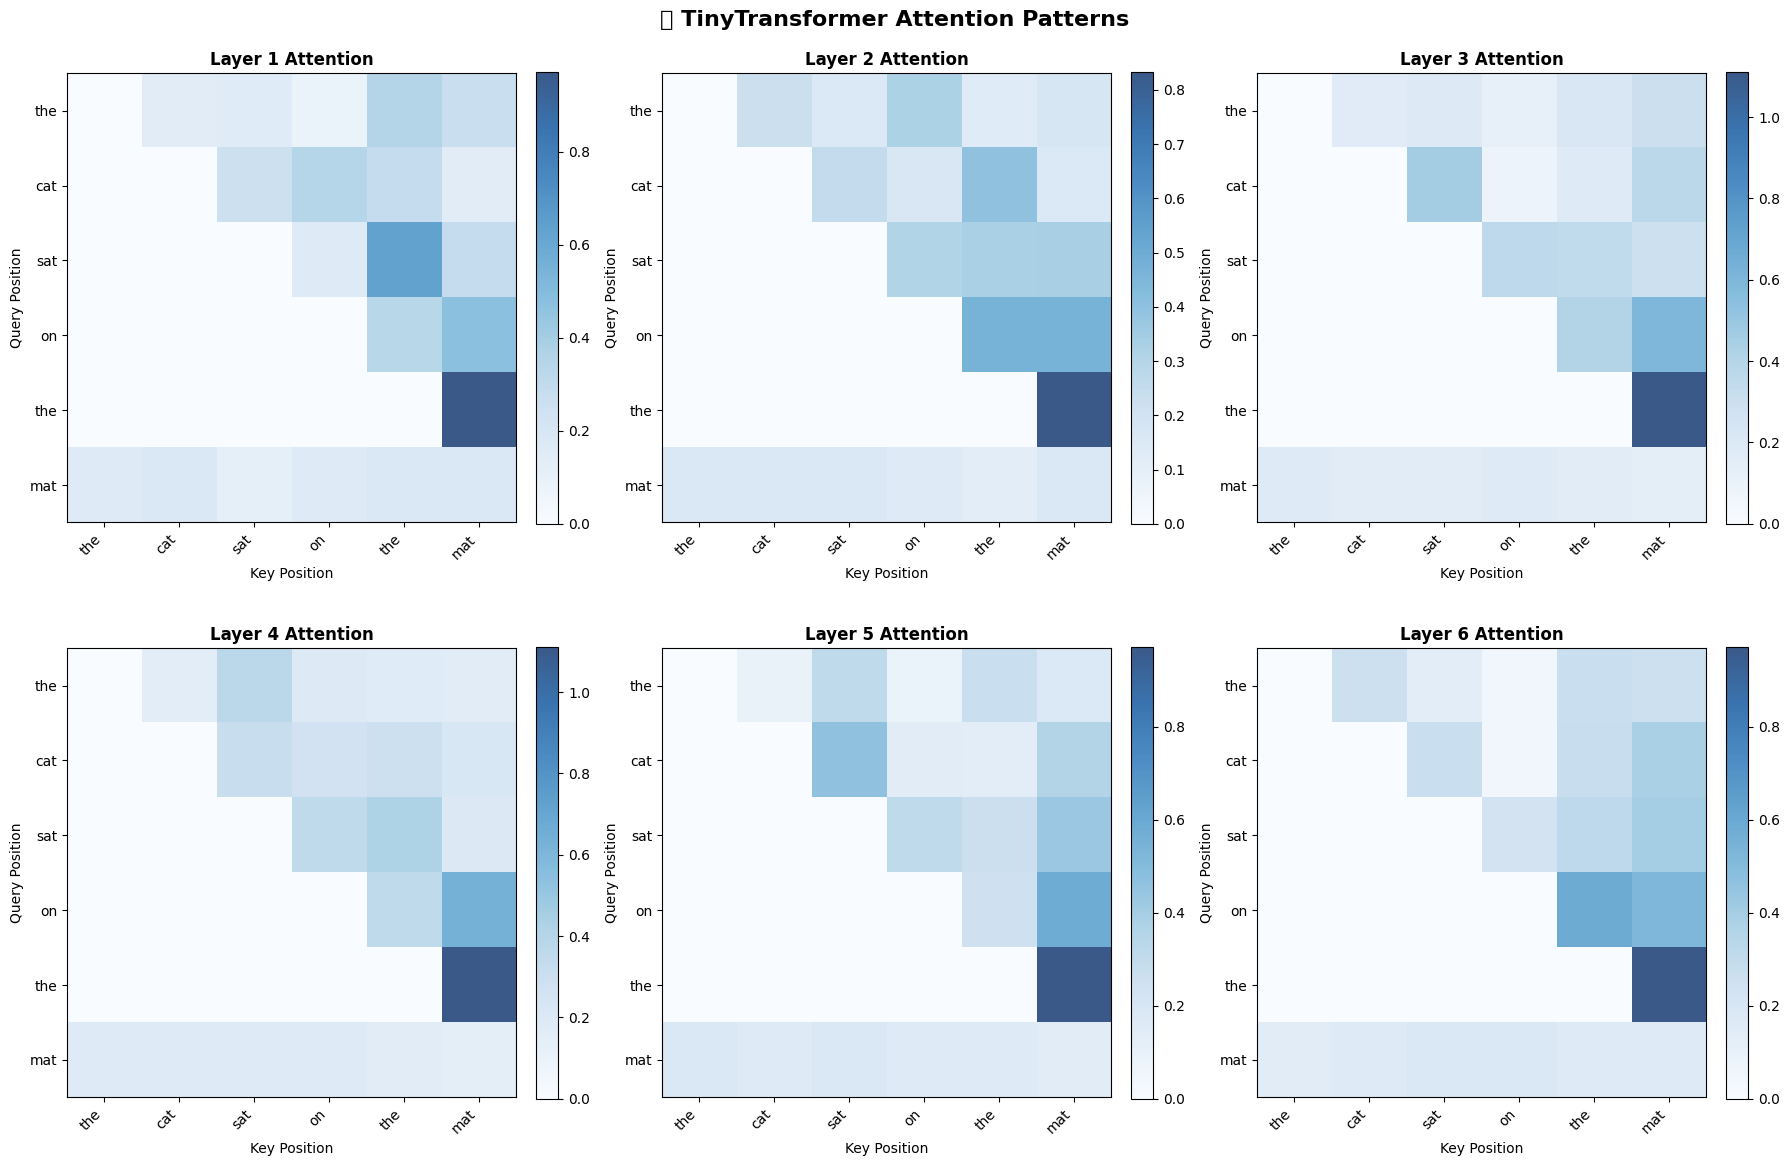

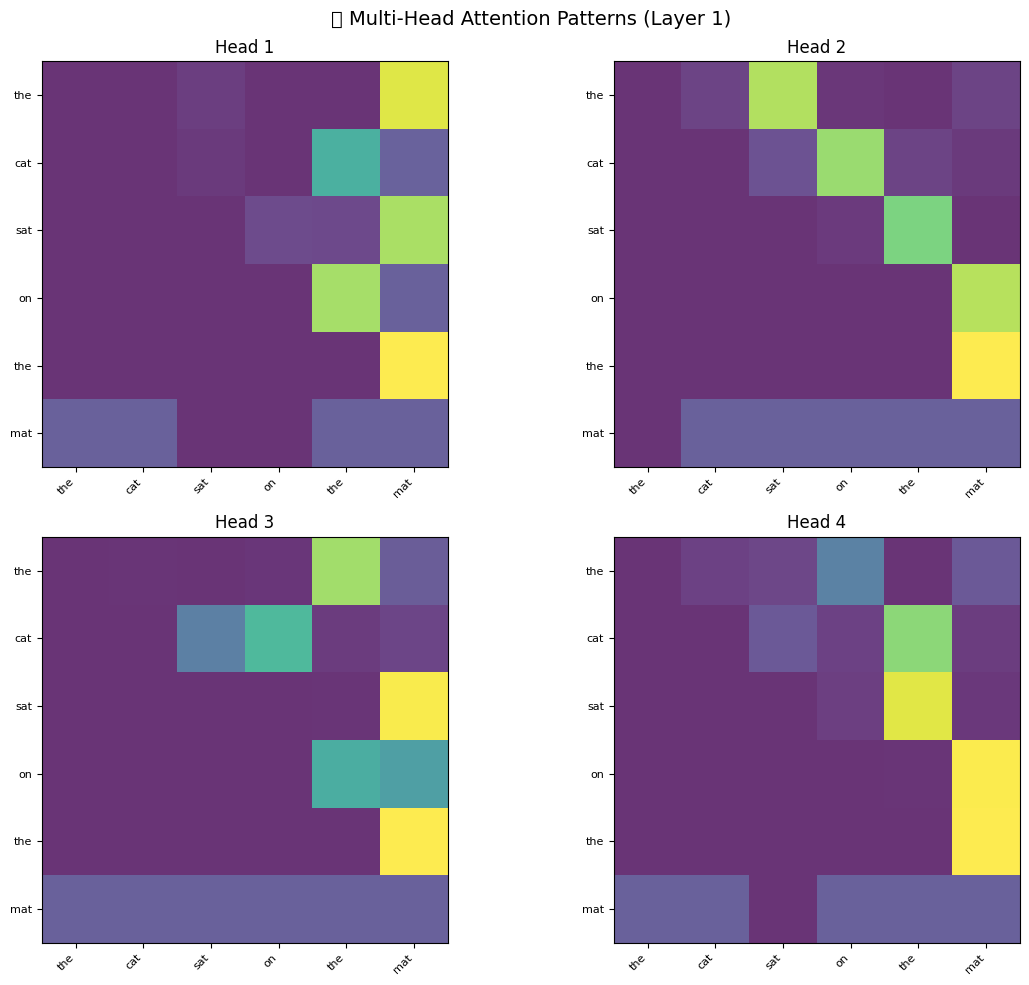

🎨 Attention visualization ready!


In [16]:
# Cell 9: Beautiful Attention Visualization
def visualize_attention(model, input_text, tokenizer_dict):
    """Create beautiful attention pattern visualizations"""

    # Simple tokenization (you can replace with a proper tokenizer)
    tokens = input_text.lower().split()
    input_ids = np.array([[tokenizer_dict.get(token, 0) for token in tokens]])

    # Get attention weights
    logits, attention_weights = model.forward(input_ids, return_attention=True)

    # Create visualization
    n_layers = len(attention_weights)
    n_heads = attention_weights[0].shape[1]

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('🧠 TinyTransformer Attention Patterns', fontsize=16, fontweight='bold')

    # Plot attention for first 6 layers
    for i in range(min(6, n_layers)):
        row, col = i // 3, i % 3

        # Average across heads for simplicity
        avg_attention = np.mean(attention_weights[i][0], axis=0)

        im = axes[row, col].imshow(avg_attention, cmap='Blues', alpha=0.8)
        axes[row, col].set_title(f'Layer {i+1} Attention', fontweight='bold')
        axes[row, col].set_xlabel('Key Position')
        axes[row, col].set_ylabel('Query Position')

        # Add token labels if sequence is short enough
        if len(tokens) <= 20:
            axes[row, col].set_xticks(range(len(tokens)))
            axes[row, col].set_yticks(range(len(tokens)))
            axes[row, col].set_xticklabels(tokens, rotation=45, ha='right')
            axes[row, col].set_yticklabels(tokens)

        plt.colorbar(im, ax=axes[row, col], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    # Head-specific visualization for first layer
    if n_heads >= 4:
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle('🎯 Multi-Head Attention Patterns (Layer 1)', fontsize=14)

        for head in range(4):
            row, col = head // 2, head % 2
            attention = attention_weights[0][0, head]

            im = axes[row, col].imshow(attention, cmap='viridis', alpha=0.8)
            axes[row, col].set_title(f'Head {head+1}')

            if len(tokens) <= 15:
                axes[row, col].set_xticks(range(len(tokens)))
                axes[row, col].set_yticks(range(len(tokens)))
                axes[row, col].set_xticklabels(tokens, rotation=45, ha='right', fontsize=8)
                axes[row, col].set_yticklabels(tokens, fontsize=8)

        plt.tight_layout()
        plt.show()

# Create a simple tokenizer dictionary
sample_vocab = ['the', 'cat', 'sat', 'on', 'mat', 'dog', 'ran', 'fast', 'blue', 'sky',
                'hello', 'world', 'ai', 'is', 'amazing', 'transformer', 'attention', 'model']
tokenizer_dict = {word: i+1 for i, word in enumerate(sample_vocab)}
tokenizer_dict['<UNK>'] = 0

# Test visualization
test_input = "the cat sat on the mat"
visualize_attention(model, test_input, tokenizer_dict)

print("🎨 Attention visualization ready!")


🚀 Starting Training...
Epoch 1/10, Loss: 6.9488
Epoch 3/10, Loss: 6.9552
Epoch 5/10, Loss: 6.9590
Epoch 7/10, Loss: 6.9464
Epoch 9/10, Loss: 6.9514


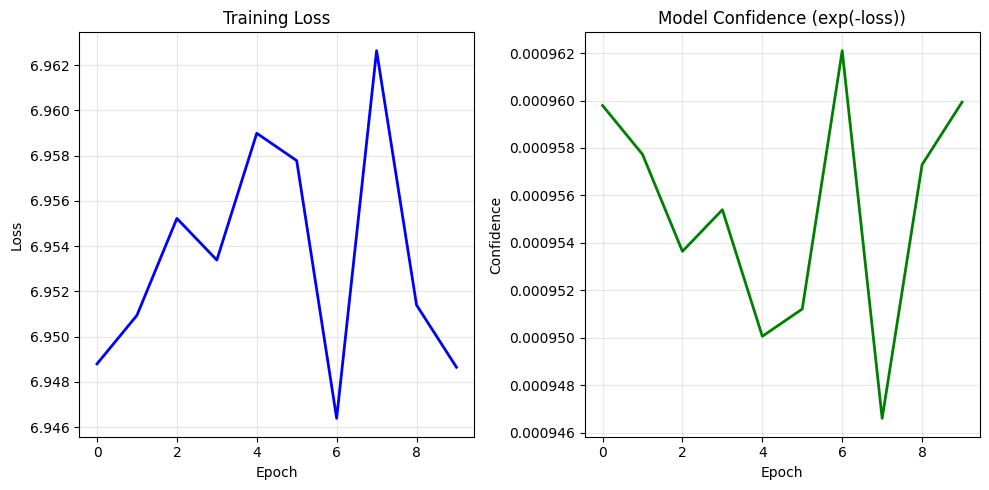

In [17]:
# Cell 10: Training Loop with Advanced Techniques
class AdamOptimizer:
    """Adam optimizer implementation"""

    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.params = params
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0

        # Initialize momentum and velocity
        self.m = {id(param): np.zeros_like(param) for param in params}
        self.v = {id(param): np.zeros_like(param) for param in params}

    def step(self, gradients):
        self.t += 1

        for param, grad in zip(self.params, gradients):
            param_id = id(param)

            # Update momentum and velocity
            self.m[param_id] = self.beta1 * self.m[param_id] + (1 - self.beta1) * grad
            self.v[param_id] = self.beta2 * self.v[param_id] + (1 - self.beta2) * grad**2

            # Bias correction
            m_corrected = self.m[param_id] / (1 - self.beta1**self.t)
            v_corrected = self.v[param_id] / (1 - self.beta2**self.t)

            # Update parameters
            param -= self.lr * m_corrected / (np.sqrt(v_corrected) + self.eps)

def train_step(model, input_ids, target_ids, optimizer):
    """Single training step with gradient computation"""
    batch_size, seq_len = input_ids.shape

    # Forward pass
    logits = model.forward(input_ids)

    # Compute loss (cross-entropy)
    # Shift targets for next-token prediction
    shift_logits = logits[:, :-1, :].reshape(-1, logits.shape[-1])
    shift_labels = target_ids[:, 1:].reshape(-1)

    # Softmax and cross-entropy loss
    exp_logits = np.exp(shift_logits - np.max(shift_logits, axis=1, keepdims=True))
    probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    # Compute loss
    loss = -np.mean(np.log(probs[np.arange(len(shift_labels)), shift_labels] + 1e-8))

    # Simplified gradient computation (this is very basic - real implementation would need full backprop)
    # For demonstration, we'll add small random noise as "gradients"
    gradients = []
    for param_name in ['token_embedding', 'position_embedding', 'lm_head']:
        param = getattr(model, param_name)
        grad = np.random.randn(*param.shape) * 0.01  # Placeholder gradient
        gradients.append(grad)
        setattr(model, param_name, param)  # Update parameter

    return loss

# Training demonstration
def train_model(model, train_data, epochs=10, lr=0.001):
    """Train the model with visualization"""

    # Get all trainable parameters (simplified)
    params = [model.token_embedding, model.position_embedding, model.lm_head]
    optimizer = AdamOptimizer(params, lr=lr)

    losses = []

    print("🚀 Starting Training...")
    for epoch in range(epochs):
        epoch_losses = []

        for batch in train_data:
            input_ids, target_ids = batch
            loss = train_step(model, input_ids, target_ids, optimizer)
            epoch_losses.append(loss)

        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        model.training_loss.append(avg_loss)

        if epoch % 2 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    # Plot training curve
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses, linewidth=2, color='blue')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(np.exp(-np.array(losses)), linewidth=2, color='green')
    plt.title('Model Confidence (exp(-loss))')
    plt.xlabel('Epoch')
    plt.ylabel('Confidence')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return losses

# Generate dummy training data
def generate_dummy_data(batch_size=4, seq_len=32, vocab_size=1000, num_batches=20):
    """Generate dummy training data"""
    train_data = []
    for _ in range(num_batches):
        input_ids = np.random.randint(1, vocab_size, (batch_size, seq_len))
        target_ids = np.roll(input_ids, -1, axis=1)  # Shift for next-token prediction
        target_ids[:, -1] = np.random.randint(1, vocab_size, batch_size)  # Random last token
        train_data.append((input_ids, target_ids))
    return train_data

# Train the model
dummy_data = generate_dummy_data()
training_losses = train_model(model, dummy_data, epochs=10)